# Zomato Restaurant Data Analysis & Feature Engineering

**Objective:**  
Clean, analyze, and engineer features from the Zomato dataset to produce a model-ready dataset.


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv("zomato.csv")
df.head()


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [2]:
df.isnull().sum().sort_values(ascending=False).head(10)

dish_liked                     28078
rate                            7775
phone                           1208
approx_cost(for two people)      346
rest_type                        227
cuisines                          45
location                          21
url                                0
address                            0
votes                              0
dtype: int64

In [22]:
df['rate'] = (
    df['rate']
    .replace(['NEW', '-'], np.nan)
    .astype(str)
    .str.split('/')
    .str[0]
)

df['rate'] = pd.to_numeric(df['rate'], errors='coerce')
df['rate'] = df['rate'].fillna(df['rate'].mean())
df['rate'].isna().sum()

np.int64(0)

In [15]:
df['approx_cost(for two people)'] = (
    df['approx_cost(for two people)']
    .astype(str)
    .str.replace(',', '')
)

df['approx_cost(for two people)'] = pd.to_numeric(
    df['approx_cost(for two people)'], errors='coerce'
)

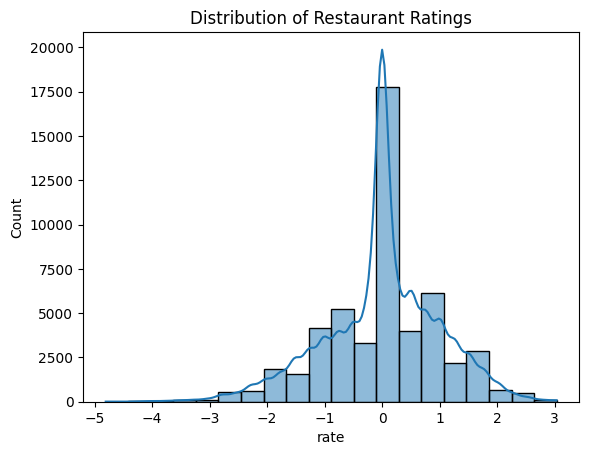

In [23]:
sns.histplot(df['rate'], bins=20, kde=True)
plt.title("Distribution of Restaurant Ratings")
plt.show()

In [7]:
df['Cuisine_Count'] = df['cuisines'].str.split(',').str.len()
df[['Cuisine_Count']].describe()


,Cuisine_Count
count,51672.000000
mean,2.454308
std,1.270274
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,8.000000


In [8]:
df['location'].value_counts().head(10)


location
BTM                      5124
HSR                      2523
Koramangala 5th Block    2504
JP Nagar                 2235
Whitefield               2144
Indiranagar              2083
Jayanagar                1926
Marathahalli             1846
Bannerghatta Road        1630
Bellandur                1286
Name: count, dtype: int64

In [16]:
scaler = StandardScaler()
df[['rate', 'approx_cost(for two people)']] = scaler.fit_transform(
    df[['rate', 'approx_cost(for two people)']]
)

df.shape

(51717, 18)